In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchmetrics

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm.autonotebook import tqdm

plt.style.use('dark_background')
warnings.filterwarnings('ignore', 'FutureWarning')

## Create Dataset

In [2]:
class Dataset2Class(Dataset):
    def __init__(self, path_dir1: str, path_dir2: str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        # Получение списков, содержащих имена файлов и директорий в 
        # каталогах path_dir1, path_dir2
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        
        self.len_dir1_list = len(self.dir1_list)
    
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    def __getitem__(self, idx):
        if idx < self.len_dir1_list:
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= self.len_dir1_list
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
            
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.0
        img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        return {'img': t_img, 'label': t_class_id}

In [3]:
# 0 - dogs, 1 - cats

train_dogs_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/train/dogs'
train_cats_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/train/cats'

test_dogs_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/valid/dogs'
test_cats_path = '/kaggle/input/dog-vs-cat-fastai/dogscats/valid/cats'

train_dataset = Dataset2Class(train_dogs_path, train_cats_path)
test_dataset = Dataset2Class(test_dogs_path, test_cats_path)

In [4]:
train_dataset[0]['img']

tensor([[[0.4536, 0.5949, 0.6169,  ..., 0.6065, 0.5729, 0.5345],
         [0.4742, 0.6113, 0.6414,  ..., 0.6232, 0.5934, 0.5571],
         [0.4903, 0.6155, 0.6425,  ..., 0.6447, 0.6131, 0.5803],
         ...,
         [0.4982, 0.4829, 0.3850,  ..., 0.2927, 0.2700, 0.2355],
         [0.4240, 0.4010, 0.2927,  ..., 0.2814, 0.2600, 0.2463],
         [0.2724, 0.2703, 0.2946,  ..., 0.2682, 0.2598, 0.2689]],

        [[0.4449, 0.5945, 0.6208,  ..., 0.6143, 0.5807, 0.5410],
         [0.4655, 0.6109, 0.6453,  ..., 0.6311, 0.6013, 0.5696],
         [0.4816, 0.6151, 0.6464,  ..., 0.6526, 0.6209, 0.5902],
         ...,
         [0.4880, 0.4526, 0.3764,  ..., 0.3241, 0.3085, 0.2748],
         [0.3921, 0.3912, 0.3207,  ..., 0.3128, 0.2984, 0.2855],
         [0.3021, 0.3215, 0.3244,  ..., 0.3069, 0.2957, 0.3056]],

        [[0.4987, 0.6166, 0.6404,  ..., 0.6614, 0.6278, 0.5828],
         [0.5193, 0.6329, 0.6649,  ..., 0.6781, 0.6483, 0.6097],
         [0.5354, 0.6371, 0.6661,  ..., 0.7095, 0.6686, 0.

## Create Dataloader

In [5]:
batch_size = 16
train_loader = DataLoader(train_dataset, 
                          shuffle=True, 
                          drop_last=True,
                          batch_size=batch_size,
                         )
test_loader = DataLoader(test_dataset,
                        shuffle=True,
                        batch_size=batch_size,
                        )

## Architecture CNN

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1)) # Автоматически рассчитывает значения
                                                        # для достижения указанного рамера
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 10)
        self.linear2 = nn.Linear(10, 2)
        
    def forward(self, x):
        # Сверточная сеть
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.adaptivepool(x)
        
        # Полносвязная сеть
        x = self.flatten(x)
   
        x = self.linear1(x)
        x = self.leaky_relu(x)
        
        x = self.linear2(x)
        
        return x

In [7]:
model = ConvNet()

In [8]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [9]:
for sample in train_loader:
    img = sample['img']
    print(img.shape)
    model(img)
    break

torch.Size([16, 3, 50, 50])


## Learn CNN

In [10]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

model = model.to(DEVICE)
EPOCHS = 15
accuracy = torchmetrics.Accuracy(task='binary').to(DEVICE)

In [11]:
# def accuracy(pred: torch.Tensor, target: torch.Tensor) -> int:
#     proba = F.softmax(pred, dim=1)
#     true = (torch.argmax(pred.detach(), dim=1) == torch.argmax(target, dim=1)).sum()
#     return true.to(torch.float32).mean().detach().cpu().numpy().item()

In [12]:
train_loss = []
total_loss = []

val_loss = []
total_val_loss = []

acc_train = []
acc_val = []

size = len(train_dataset)

In [13]:
for epoch in tqdm(range(EPOCHS)):
    print(f'Epochs {epoch+1} \n------------------------')
    for iteration, tensor in enumerate(train_loader):
        
        X_batch = tensor.get('img').to(DEVICE)
        y_batch = tensor.get('label').to(DEVICE)
        y_batch = F.one_hot(y_batch, 2).to(torch.float32)
        
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
    
        loss.backward()
        
        acc = accuracy(outputs, y_batch)
        
        acc_train.append(acc.detach().cpu().numpy().item())
        train_loss.append(loss.detach().cpu().numpy().item())
        
        optimizer.step()
        
        current = (iteration + 1) * len(X_batch)
        if current % 1000 == 0:
            print(f'loss: {loss:>7f} [{current}|{size:>2d}] Accuracy: {np.mean(acc_train)}')
    
    total_loss.append(np.mean(train_loss)) # для графика
    for iteration, tensor in enumerate(test_loader):
        X_val = tensor.get('img').to(DEVICE)
        y_val = tensor.get('label').to(DEVICE)
        y_val = F.one_hot(y_val, 2).to(torch.float32)
        with torch.no_grad():
            model.eval()
            
            outputs = model(X_val)
            
            loss = loss_function(outputs, y_val)
            acc = accuracy(outputs, y_val)
            
            acc_val.append(acc.detach().cpu().numpy().item())
            val_loss.append(loss.detach().cpu().numpy().item())
            
    total_val_loss.append(np.mean(val_loss)) # для графика
    print(f'Validation Error:\nAccuracy: {np.mean(acc_val)} Avg Loss: {np.mean(val_loss)}')

  0%|          | 0/15 [00:00<?, ?it/s]

Epochs 1 
------------------------
loss: 0.700168 [2000|23000] Accuracy: 0.511
loss: 0.690690 [4000|23000] Accuracy: 0.513
loss: 0.718215 [6000|23000] Accuracy: 0.5169166666666667
loss: 0.658749 [8000|23000] Accuracy: 0.514875
loss: 0.638568 [10000|23000] Accuracy: 0.521
loss: 0.654864 [12000|23000] Accuracy: 0.5287916666666667
loss: 0.630629 [14000|23000] Accuracy: 0.5348214285714286
loss: 0.727971 [16000|23000] Accuracy: 0.542125
loss: 0.649398 [18000|23000] Accuracy: 0.5501111111111111
loss: 0.689196 [20000|23000] Accuracy: 0.553725
loss: 0.706678 [22000|23000] Accuracy: 0.5589090909090909
Validation Error:
Accuracy: 0.57575 Avg Loss: 0.6686826138496399
Epochs 2 
------------------------
loss: 0.681420 [2000|23000] Accuracy: 0.5663012163892446
loss: 0.718416 [4000|23000] Accuracy: 0.5708172791938352
loss: 0.634178 [6000|23000] Accuracy: 0.57560706401766
loss: 0.632433 [8000|23000] Accuracy: 0.5799399845121321
loss: 0.658957 [10000|23000] Accuracy: 0.5833535402521823
loss: 0.590855 [

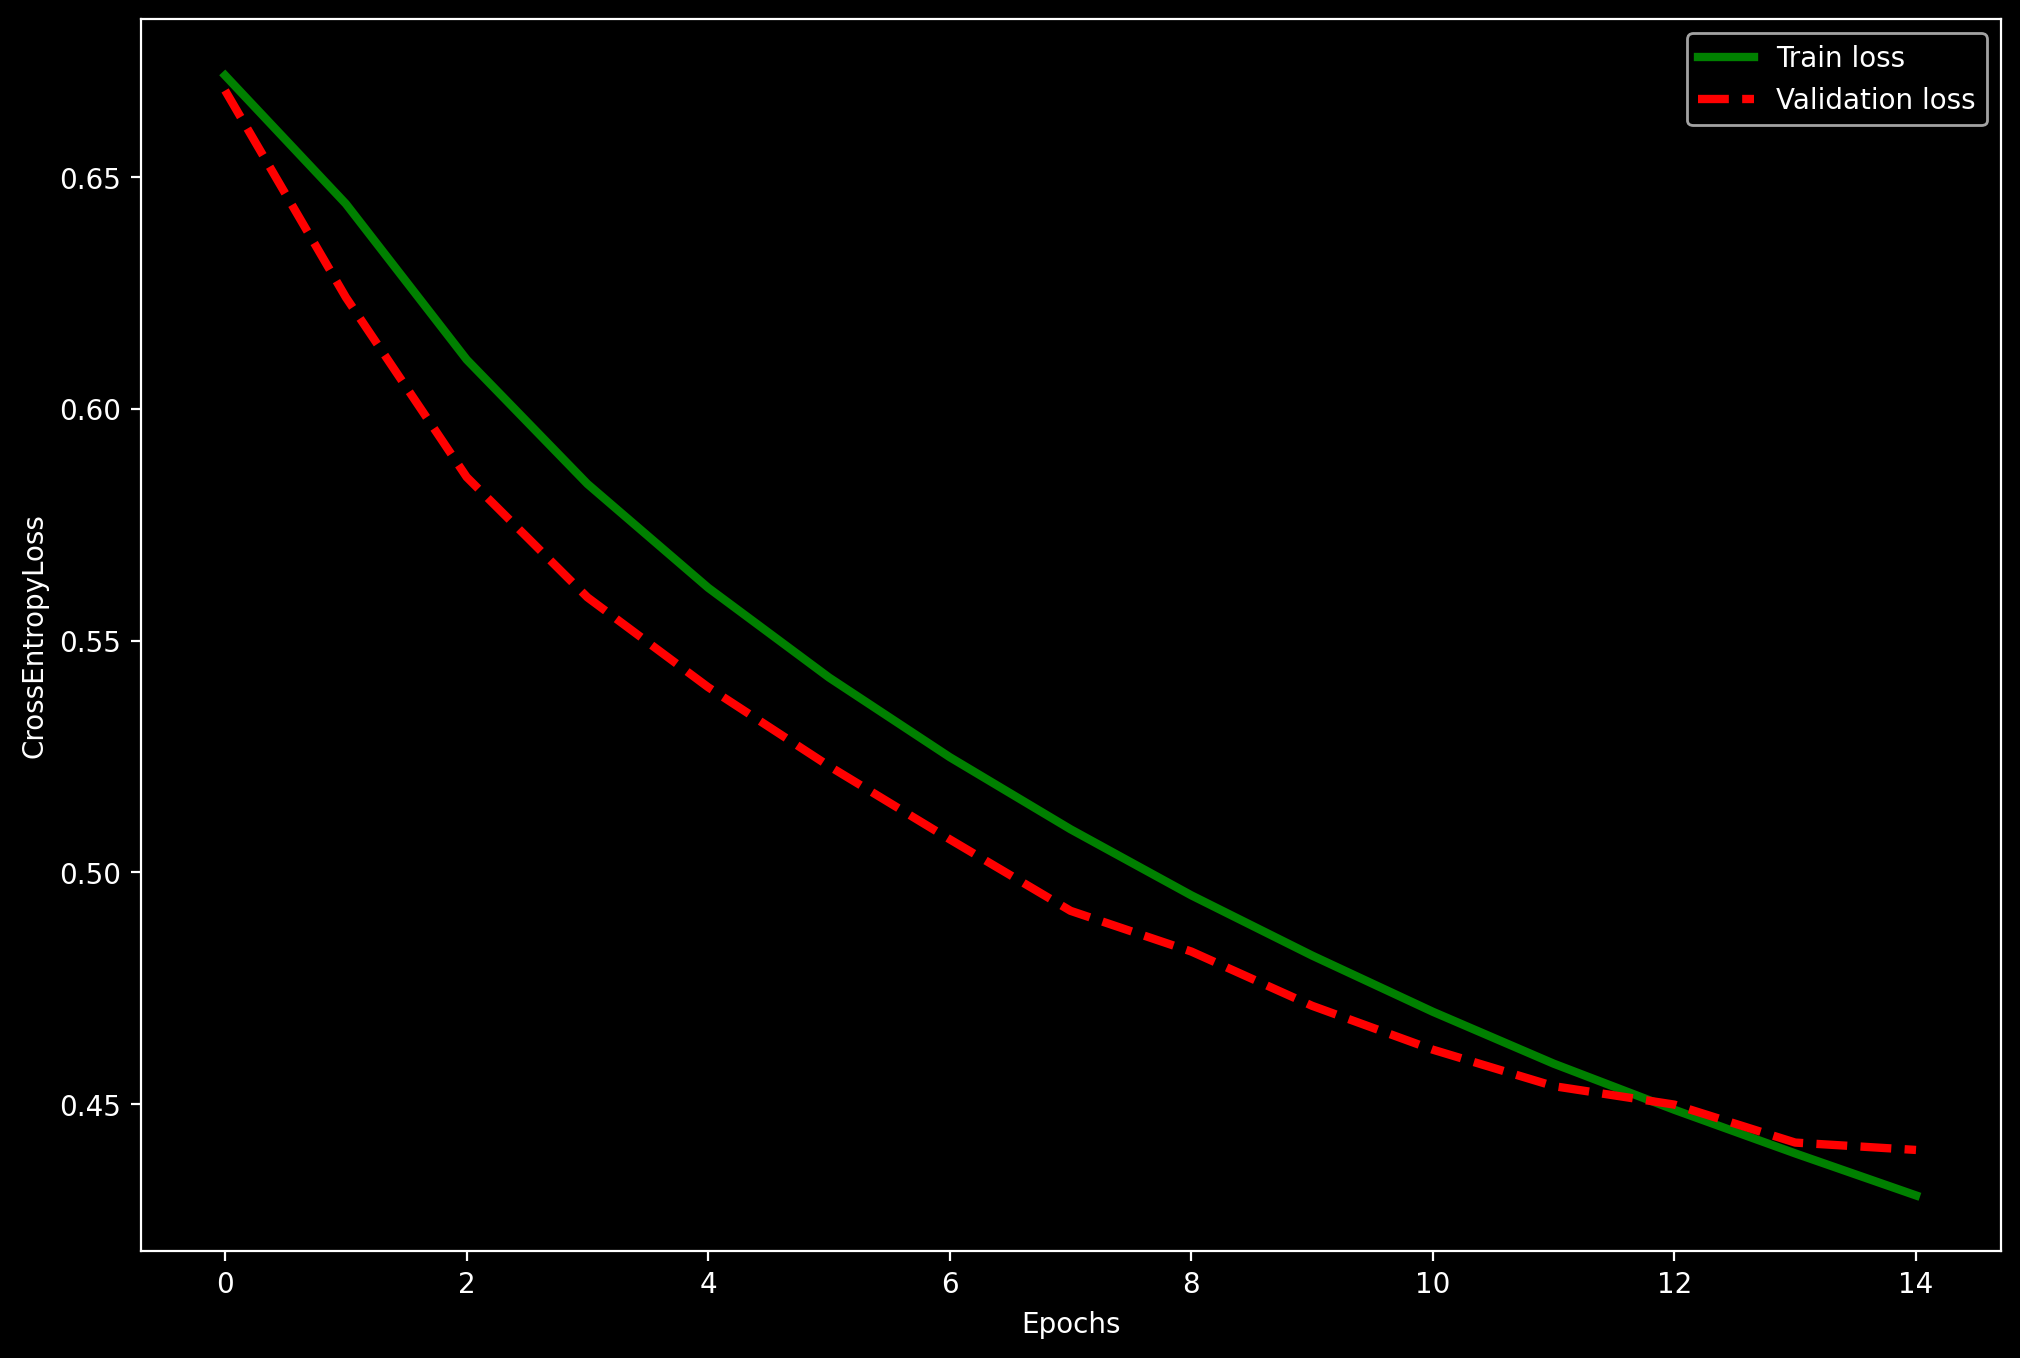

In [14]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(total_loss, color='green', label='Train loss', linewidth=3)
plt.plot(total_val_loss, color='red', label='Validation loss', linestyle='--', linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend();

## Save model

In [15]:
checkpoints = {'model': ConvNet(),
               'state_dict': model.state_dict(),
               'optimizer': optimizer.state_dict()}

In [16]:
torch.save(checkpoints, 'checkpoint_1.pth')

## Predict

In [17]:
def upload_img(img_path:str) -> np.array:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [18]:
def edit_img(img: np.array) -> torch.Tensor:
    img = img.astype(np.float32)
    img = img / 255.0
    img = cv2.resize(img, (50, 50), cv2.INTER_AREA)
    plt.imshow(img)
    
    img = img.transpose((2,  0, 1))
    img = np.expand_dims(img, 0)
    t_img = torch.from_numpy(img)
    return t_img

In [19]:
def predict(model, img: torch.Tensor) -> int:
    with torch.no_grad():
        model.eval()
        pred = model(img)
        
        sigmoid = torch.sigmoid(pred)[0]

        print(f'Вероятность, что это кошка составляет: {sigmoid[1]}\nВероятность, что это собака составляет: {sigmoid[0]}')
        
        pred = torch.argmax(pred, 1)
    return pred.detach().cpu().numpy().item()

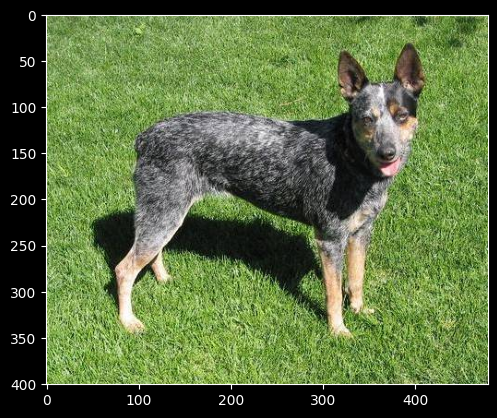

In [20]:
img = upload_img('/kaggle/input/dog-vs-cat-fastai/dogscats/test1/10030.jpg')
plt.imshow(img)

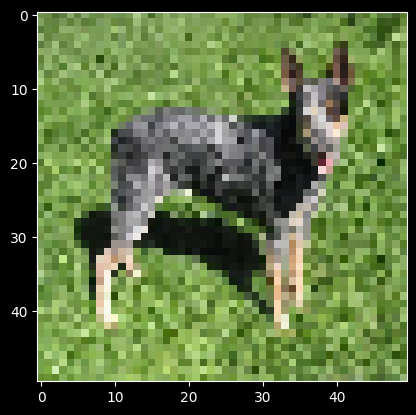

In [21]:
img = edit_img(img)

In [22]:
img.shape

torch.Size([1, 3, 50, 50])

In [23]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(DEVICE)
img = img.to(DEVICE)

In [24]:
if predict(model, img):
    print('Кошка')
else:
    print('Собака')

Вероятность, что это кошка составляет: 0.15594267845153809
Вероятность, что это собака составляет: 0.5383994579315186
Собака


## Load the Model

In [25]:
def load_checkpoint(filepath: str):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [26]:
model = load_checkpoint('checkpoint_1.pth')
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)
